Running test code for part 1
--------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10:
Training Loss: 0.561559347808361
Training Accuracy: 0.6748
Validation Accuracy: 0.8592



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10:
Training Loss: 0.2666244987398386
Training Accuracy: 0.888
Validation Accuracy: 0.8668



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10:
Training Loss: 0.1447750275954604
Training Accuracy: 0.9596
Validation Accuracy: 0.8796



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10:
Training Loss: 0.07195402823854238
Training Accuracy: 0.9752
Validation Accuracy: 0.8852



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10:
Training Loss: 0.037118682215805165
Training Accuracy: 0.9872
Validation Accuracy: 0.8488



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10:
Training Loss: 0.039278462796937676
Training Accuracy: 0.9892
Validation Accuracy: 0.8756



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10:
Training Loss: 0.028623947105370463
Training Accuracy: 0.992
Validation Accuracy: 0.886



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10:
Training Loss: 0.026728366647148505
Training Accuracy: 0.9924
Validation Accuracy: 0.8788



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10:
Training Loss: 0.028023137152194975
Training Accuracy: 0.9928
Validation Accuracy: 0.8732



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10:
Training Loss: 0.022557691184920257
Training Accuracy: 0.9928
Validation Accuracy: 0.8772



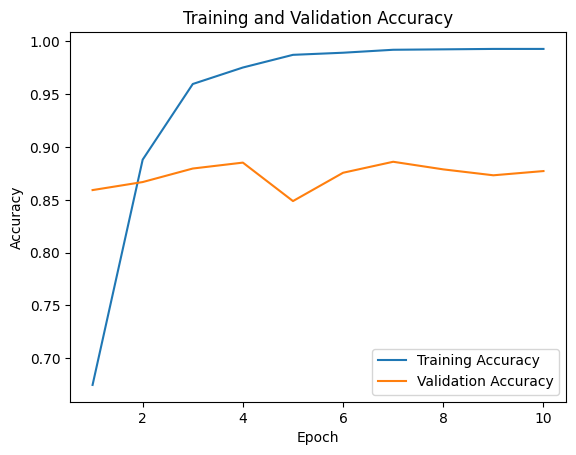

Pair 1:
Premise: Group sweeping away leakage while bystanders look on.
Hypothesis: A single man sweeps in a lonely alley.
True Label: 1
Predicted Label: 1.0

Pair 2:
Premise: A dog with big ears holds a ball in his mouth.
Hypothesis: The dog has big ears.
True Label: 0
Predicted Label: 0.0

Pair 3:
Premise: A runner in a yellow shirt is running a race.
Hypothesis: A runner is watching people run.
True Label: 1
Predicted Label: 1.0



In [3]:
import random
from typing import Union
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import transformers
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score  # Make sure sklearn is installed


def load_datasets(data_directory: str) -> Union[dict, dict]:
    """
    Reads the training and validation splits from disk and load
    them into memory.

    Parameters
    ----------
    data_directory: str
        The directory where the data is stored.
    
    Returns
    -------
    train: dict
        The train dictionary with keys 'premise', 'hypothesis', 'label'.
    validation: dict
        The validation dictionary with keys 'premise', 'hypothesis', 'label'.
    """
    import json
    import os

    with open(os.path.join(data_directory, "train.json"), "r") as f:
        train = json.load(f)

    with open(os.path.join(data_directory, "validation.json"), "r") as f:
        valid = json.load(f)

    return train, valid


class NLIDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict: dict):
        self.data_dict = data_dict
        dd = data_dict

        if len(dd["premise"]) != len(dd["hypothesis"]) or len(dd["premise"]) != len(
            dd["label"]
        ):
            raise AttributeError("Incorrect length in data_dict")

    def __len__(self):
        return len(self.data_dict["premise"])

    def __getitem__(self, idx):
        dd = self.data_dict
        return dd["premise"][idx], dd["hypothesis"][idx], dd["label"][idx]


def train_distilbert(model, loader, device):
    model.train()
    criterion = model.get_criterion()
    total_loss = 0.0

    for premise, hypothesis, target in tqdm(loader):
        optimizer.zero_grad()

        inputs = model.tokenize(premise, hypothesis).to(device)
        target = target.to(device, dtype=torch.float32)

        pred = model(inputs)

        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def eval_distilbert(model, loader, device):
    model.eval()

    targets = []
    preds = []

    for premise, hypothesis, target in loader:
        preds.append(model(model.tokenize(premise, hypothesis).to(device)))

        targets.append(target)

    return torch.cat(preds), torch.cat(targets)


class CustomDistilBert(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Load the DistilBERT model's pretrained "base uncased" weights from the Huggingface
        # repository. We want the bare encoder outputting hidden-states without any specific head on top.
        self.distilbert = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')
        # Load the corresponding pre-trained tokenizer using the same method.
        self.tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        # self.pred_layer takes the output of the model and predicts a single score (binary, 1 or 0), then pass the output to the sigmoid layer
        self.pred_layer = nn.Linear(self.distilbert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        # self.criterion should be the binary cross-entropy loss. You may use torch.nn here
        self.criterion = nn.BCELoss()

    def get_distilbert(self):
        return self.distilbert

    def get_tokenizer(self):
        return self.tokenizer

    def get_pred_layer(self):
        return self.pred_layer

    def get_sigmoid(self):
        return self.sigmoid
    
    def get_criterion(self):
        return self.criterion

    def assign_optimizer(self, **kwargs):
        optimizer = torch.optim.Adam(self.parameters(), **kwargs)
        return optimizer

    def slice_cls_hidden_state(
        self, x: transformers.modeling_outputs.BaseModelOutput
    ) -> torch.Tensor:
        # Extract the hidden states of the last layer. Shape:  [batch_size, sequence_length, hidden_size]
        last_hidden_states = x.last_hidden_state
        # The last layer's hidden state representing the [CLS] token. Usually, CLS is the first token in the sequence.
        cls_hidden_state = last_hidden_states[:, 0, :]
        return cls_hidden_state

    def tokenize(
        self,
        premise: "list[str]",
        hypothesis: "list[str]",
        max_length: int = 128,
        truncation: bool = True,
        padding: bool = True,
    ):
        # Using the tokenizer
        tokenizer = self.get_tokenizer()
        inputs = tokenizer(
            premise,
            hypothesis,
            max_length=max_length,
            truncation=truncation,
            padding=padding,
            return_tensors="pt",
            return_token_type_ids=False,
            return_attention_mask=True,
        )
        return inputs

    def forward(self, inputs: transformers.BatchEncoding):
        # Get output from model(input)
        outputs = self.distilbert(**inputs)
        # Get hidden state [cls]
        cls_hidden_state = self.slice_cls_hidden_state(outputs)
        # Pass through last year and get 0,1
        logits = self.pred_layer(cls_hidden_state)
        # Get probability distribution from logits
        probabilities = self.sigmoid(logits.squeeze(dim=1))
        return probabilities

def freeze_params(model):
    for param in model.parameters():
        param.requires_grad = False


def pad_attention_mask(mask, p):
    # pad p times
    batch_size, seq_len = mask.shape

    padding = torch.ones((batch_size, p), dtype=torch.int64) 
    padded_mask = torch.cat([padding, mask], dim=1)

    return padded_mask


class SoftPrompting(nn.Module):
    def __init__(self, p: int, e: int):
        super().__init__()
        self.p = p
        self.e = e
        
        self.prompts = torch.randn((p, e), requires_grad=True)
        
    def forward(self, embedded):
        # Grab the batch size
        batch_size, _, _ = embedded.size()
        
        # Expand prompts separately
        expanded_prompts = self.prompts.unsqueeze(0).expand(batch_size, self.p, self.e)
        
        # Then concat with the embedding
        output_embed = torch.cat((expanded_prompts, embedded), dim=1)
        
        return output_embed

def load_models_and_tokenizer(q_name, a_name, t_name, device='cpu'):
    # question encoder model
    q_enc = transformers.AutoModel.from_pretrained(q_name).to(device)
    
    # answer encoder model
    a_enc = transformers.AutoModel.from_pretrained(a_name).to(device)
    
    # tokenizer
    tokenizer = transformers.AutoTokenizer.from_pretrained(t_name)
    
    return q_enc, a_enc, tokenizer
    

def tokenize_qa_batch(tokenizer, q_titles, q_bodies, answers, max_length=64) -> transformers.BatchEncoding:
    # 'pt': Return PyTorch torch.Tensor objects.
    # tokenize the question titles and bodies
    q_batch = tokenizer(q_titles, q_bodies, max_length=max_length, truncation=True, padding='longest', return_tensors='pt')

    # tokenize answers
    a_batch = tokenizer(answers, max_length=max_length, truncation=True, padding='longest', return_tensors='pt')

    return q_batch, a_batch

def get_class_output(model, batch):
    '''
    #Extract the hidden states of the last layer. Shape:  [batch_size, sequence_length, hidden_size]
    last_hidden_states = x.last_hidden_state
    # The last layer's hidden state representing the [CLS] token. Usually, CLS is the first token in the sequence.
    cls_hidden_state = last_hidden_states[:, 0, :]
    return cls_hidden_state
    '''
    # Need the output of the model unlike above where we get it
    output = model(**batch)
    
    # Extract the representation of the class token [CLS]
    cls_hidden_state = output.last_hidden_state[:, 0, :]
    
    return cls_hidden_state

def inbatch_negative_sampling(Q: Tensor, P: Tensor, device: str = 'cpu') -> Tensor:
    '''
     Let Q and P be the
    (B×d) matrix of question and passage embeddings
    in a batch of size B. S = QP^T
    is a (B × B) matrix of similarity scores, where each row of which
    corresponds to a question, paired with B passages.
    In this way, we reuse computation and effectively
    train on B2
    (qi, pj ) question/passage pairs in each
    batch. Any (qi, pj ) pair is a positive example when
    i = j, and negative otherwise
    '''
    S = torch.matmul(Q, P.t())
    return S

def contrastive_loss_criterion(S: Tensor, labels: Tensor = None, device: str = 'cpu'):
    '''
    loss = F.nll_loss(
            softmax_scores,
            torch.tensor(positive_idx_per_question).to(softmax_scores.device),
            reduction="mean",
        )
    What even is this
    '''
    
    if labels is None:
        labels = torch.arange(S.size(0), device=device)

    loss = torch.zeros(1, device=device)
    for i in range(S.size(0)):
        # iterate through each batch get positive elem
        positive_index = labels[i].item()
        positive_score = S[i, positive_index]
        
        # get the e^sim(pos)
        loss_positive = torch.exp(positive_score)
        
        # get the sum of e^sim(neg)        
        loss_negative = torch.exp(S[i][torch.arange(S.size(1)) != positive_index]).sum()
        
        fraction_loss = -torch.log(loss_positive / (loss_positive + loss_negative))
        
        # Aggregate the losses
        loss += fraction_loss
    
    # Average the loss across all questions
    loss /= S.size(0)

    return loss.squeeze()

def get_topk_indices(Q, P, k: int = None):
    # dot-product similarity scores
    sim_scores = torch.mm(Q, P.T)
    
    if k is not None:
        # get the indices of the top-k scores
        scores, indices = torch.topk(sim_scores, k, dim=1)
    else:
        # return everything in sorted order (largest to smallest)
        indices = torch.argsort(sim_scores, dim=1, descending=True)
        scores = torch.gather(sim_scores, 1, indices)
    
    return indices, scores

def select_by_indices(indices: Tensor, passages: 'list[str]') -> 'list[str]':
    # indices: Tensor[N, k] 
    '''
    The outer lists correspond to answers for the the N questions
    The inner lists contain the k sorted answers in original text format
    '''
    selection = []
    for q_idx in indices:
        selection.append([passages[idx] for idx in q_idx])
    return selection


def embed_passages(passages: 'list[str]', model, tokenizer, device='cpu', max_length=512):
    # set the model into the evaluation mode and disable gradients
    model.eval()
    with torch.no_grad():
        # tokenize
        tok_passages = tokenizer(passages, max_length=max_length, truncation=True, padding=True, return_tensors="pt")
        # send to device
        tok_passages = {key: tensor.to(device) for key, tensor in tok_passages.items()}
        # get the output and then embed
        emb_passages = get_class_output(model, tok_passages)
        
    return emb_passages


def embed_questions(titles, bodies, model, tokenizer, device='cpu', max_length=512):
    # set the model into the evaluation mode and disable gradients
    model.eval()
    with torch.no_grad():
        # tokenize titles and bodies
        tok_batch = tokenizer(titles, bodies, max_length=max_length, truncation=True, padding=True, return_tensors="pt")
        tok_batch = {key: tensor.to(device) for key, tensor in tok_batch.items()}
        # get the output and then embed
        embeddings = get_class_output(model, tok_batch)
        
    return embeddings


def recall_at_k(retrieved_indices: 'list[list[int]]', true_indices: 'list[int]', k: int):
    correct_count = 0

    # go through the pair of indices
    for retrieved_idx, true_idx in zip(retrieved_indices, true_indices):
        # if the correct answer is in one of the k elements
        if true_idx in retrieved_idx[:k]:
            correct_count += 1

    # recall: how many correct in the list at k
    recall = correct_count / len(true_indices)
    return recall


def mean_reciprocal_rank(retrieved_indices: 'list[list[int]]', true_indices: 'list[int]'):
    ranks = []
    # length = len(retrieved_indices)
    # Iterate through each question's retrieved indices and true index
    for retrieved_idx, true_idx in zip(retrieved_indices, true_indices):
        # if the correct answer is in any of retrieved indices
        if true_idx in retrieved_idx:
            # get rank: rank {rank}}_{i} refers to the rank position of the first relevant document for the i-th query.
            # formula is 1 / rank_i
            rank_i = 1 / (retrieved_idx.index(true_idx) + 1)
            ranks.append(rank_i)
        else:
            ranks.append(0.0)
            
    # print(ranks)
    # now get the mean: 1/len * sum(1/rank_i)
    mrr = sum(ranks) / len(ranks)

    return mrr

if __name__ == "__main__":

    random.seed(2022)
    torch.manual_seed(2022)

    # Parameters (you can change them)
    sample_size = 2500  # Change this if you want to take a subset of data for testing
    batch_size = 64
    n_epochs = 2
    num_words = 50000

    # If you use GPUs, use the code below:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ## TEST CODE
    train_raw, valid_raw = load_datasets("data/nli")
    if sample_size is not None:
        for key in ["premise", "hypothesis", "label"]:
            train_raw[key] = train_raw[key][:sample_size]
            valid_raw[key] = valid_raw[key][:sample_size]

    full_text = (
        train_raw["premise"]
        + train_raw["hypothesis"]
        + valid_raw["premise"]
        + valid_raw["hypothesis"]
    )
    
    print("=" * 80)
    print("Running test code for part 1")
    print("-" * 80)

    train_loader = torch.utils.data.DataLoader(
        NLIDataset(train_raw), batch_size=batch_size, shuffle=True
    )
    valid_loader = torch.utils.data.DataLoader(
        NLIDataset(valid_raw), batch_size=batch_size, shuffle=False
    )
    model = CustomDistilBert().to(device)
    optimizer = model.assign_optimizer(lr=1e-4)
    
    train_accs = []
    valid_accs = []

    for epoch in range(n_epochs):
        loss, train_preds, train_targets = train_distilbert(model, train_loader, device=device)
        train_preds = train_preds.round()
        
        preds, targets = eval_distilbert(model, valid_loader, device=device)
        preds = preds.round()
        
        train_accuracy = accuracy_score(train_targets.cpu(), train_preds.cpu())
        val_accuracy = accuracy_score(targets.cpu(), preds.cpu())
        
        score = f1_score(targets.cpu(), preds.cpu())
        
        train_accs.append(train_accuracy)
        valid_accs.append(val_accuracy)
        
        
        print(f"Epoch {epoch + 1}/{n_epochs}:")
        print(f"Training Loss: {loss}")
        print(f"Training Accuracy: {train_accuracy}")
        print(f"Validation Accuracy: {val_accuracy}")
        print()

    # Plotting accuracy scores
    plt.plot(range(1, epoch + 2), train_accs, label='Training Accuracy')
    plt.plot(range(1, epoch + 2), valid_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
    valid_set_length = len(valid_loader.dataset)

    selected_premises = []
    selected_hypotheses = []
    true_labels = []
    predicted_labels = []

    random_indices = random.sample(range(valid_set_length), 3)

    for index in random_indices:
        premise, hypothesis, target = valid_loader.dataset[index]
        inputs = model.tokenize([premise], [hypothesis]).to(device)
        pred = model(inputs).round()

        selected_premises.append(premise)
        selected_hypotheses.append(hypothesis)
        true_labels.append(target)
        predicted_labels.append(pred.item())

    for i in range(len(selected_premises)):
        print(f"Pair {i+1}:")
        print("Premise:", selected_premises[i])
        print("Hypothesis:", selected_hypotheses[i])
        print("True Label:", true_labels[i])
        print("Predicted Label:", predicted_labels[i])
        print()
    
